In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os
import sys

project_root = os.path.abspath("..") 
sys.path.append(os.path.join(project_root, "scripts"))
from linear_regression import LinearRegressionGD

In [2]:
# Load Dataset
data_path = "../data/insurance.csv"
df = pd.read_csv(data_path)

# Display dataset information
print("Data loaded successfully!")
print(df.head())
print(df.info())
print("Columns:", df.columns)

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())
if df is not None:
    # Drop index column if it exists
    df = df.drop(columns=['index'], errors='ignore')

Data loaded successfully!
   index  age     sex     bmi  children smoker     region      charges
0      0   19  female  27.900         0    yes  southwest  16884.92400
1      1   18    male  33.770         1     no  southeast   1725.55230
2      2   28    male  33.000         3     no  southeast   4449.46200
3      3   33    male  22.705         0     no  northwest  21984.47061
4      4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage

In [3]:
 # Feature Engineering
    # BMI Categories
    df['bmi_category'] = pd.cut(df['bmi'], 
                            bins=[0, 18.5, 25, 30, float('inf')], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # Age × BMI interaction
    df['age_bmi_interaction'] = df['age'] * df['bmi']
    
    # Define features
    categorical_features = ['sex', 'smoker', 'region', 'bmi_category']
    numerical_features = ['age', 'bmi', 'children', 'age_bmi_interaction']
    
    # One-Hot Encoding
    ohe = ColumnTransformer([
        ('encoder', OneHotEncoder(drop='first'), categorical_features)
    ], remainder='passthrough')
    
    # Extract features and target
    features = ohe.fit_transform(df.drop(columns=['charges']))
    target = np.log(df['charges'].values)
    
    # Print results
    print(f"Features Shape: {features.shape}, Target Shape: {target.shape}")
    print("\nFirst 5 Log-Transformed Target Values (y):")
    print(target[:5])

Features Shape: (1338, 12), Target Shape: (1338,)

First 5 Log-Transformed Target Values (y):
[9.73417643 7.45330245 8.40053847 9.9980916  8.26019685]


In [4]:
# Split dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Standardize only numerical features
scaler = StandardScaler()

# Identify numeric feature indices (assumes categorical features are first in `features`)
num_features_start = len(ohe.named_transformers_['encoder'].get_feature_names_out())
X_train[:, num_features_start:] = scaler.fit_transform(X_train[:, num_features_start:])
X_test[:, num_features_start:] = scaler.transform(X_test[:, num_features_start:])

# Confirm the split
print(f"Training Set Shape: {X_train.shape}, Testing Set Shape: {X_test.shape}")

Training Set Shape: (1070, 12), Testing Set Shape: (268, 12)


In [5]:
# Initialize the Linear Regression model
try:
    lr = LinearRegressionGD(learning_rate=0.001, n_iter=5000)  # n_iter specifies the number of iterations/epochs for gradient descent optimization

    print("Custom Linear Regression model imported successfully!")
except NameError:
    print("Error: LinearRegressionGD is not defined. Ensure it's correctly imported.")



Custom Linear Regression model imported successfully!


In [6]:
try:
    # Train the custom model
    print("Training and evaluating custom model...")
    lr_custom = LinearRegressionGD(learning_rate=0.001, n_iter=5000)
    # Fit custom model
    lr_custom.fit(X_train, y_train)
    # Predict using custom model
    y_pred_custom = lr_custom.predict(X_test)
    # Calculate MSE for custom model
    mse_custom = mean_squared_error(y_test, y_pred_custom)

    # Train the scikit-learn model
    print("Training and evaluating scikit-learn model...")
    lr_sklearn = LinearRegression()
    # Fit scikit-learn model
    lr_sklearn.fit(X_train, y_train)
    # Predict using scikit-learn model
    y_pred_sklearn = lr_sklearn.predict(X_test)
    # Calculate MSE for scikit-learn model
    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)

    # Print comparison of model performances
    print("\nModel Performance Comparison:")
    print(f"Custom Model MSE on Test Set:            {mse_custom:.4f}")
    print(f"scikit-learn Linear Regression MSE:      {mse_sklearn:.4f}")

except Exception as e:
    print(f"An error occurred during model training/evaluation: {str(e)}")
    


Training and evaluating custom model...
Training and evaluating scikit-learn model...

Model Performance Comparison:
Custom Model MSE on Test Set:            1.0126
scikit-learn Linear Regression MSE:      0.1768


In [7]:
# Check if the logistic regression model has recorded cost values
if hasattr(lr, 'costs') and len(lr.costs) > 0:
    print("Cost values exist, proceeding with plotting.")
else:
    print("No cost values recorded. Ensure the model has been trained.")


No cost values recorded. Ensure the model has been trained.


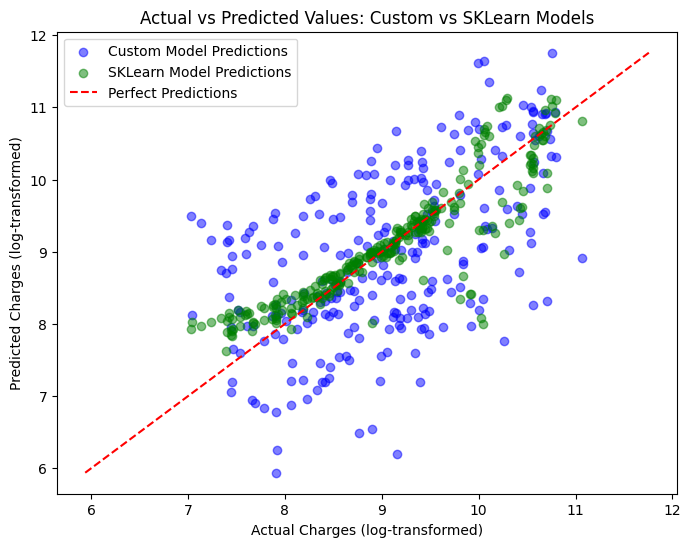

In [8]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_custom, alpha=0.5, label="Custom Model Predictions", color="blue")
plt.scatter(y_test, y_pred_sklearn, alpha=0.5, label="SKLearn Model Predictions", color="green")

# reference line (Perfect Predictions)
min_val = np.min([y_test.min(), y_pred_custom.min(), y_pred_sklearn.min()])
max_val = np.max([y_test.max(), y_pred_custom.max(), y_pred_sklearn.max()])
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label="Perfect Predictions")

plt.xlabel('Actual Charges (log-transformed)')
plt.ylabel('Predicted Charges (log-transformed)')
plt.title('Actual vs Predicted Values: Custom vs SKLearn Models')
plt.legend()
plt.show()



Comparison of Models:
Custom Model MSE: 1.0126
scikit-learn Model MSE: 0.1768
Custom Model R² Score: -0.1261
scikit-learn R² Score: 0.8033


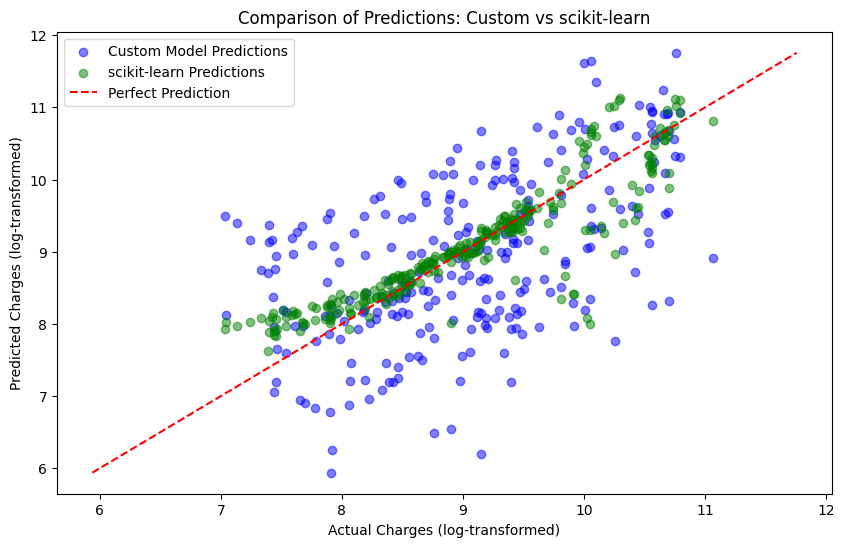

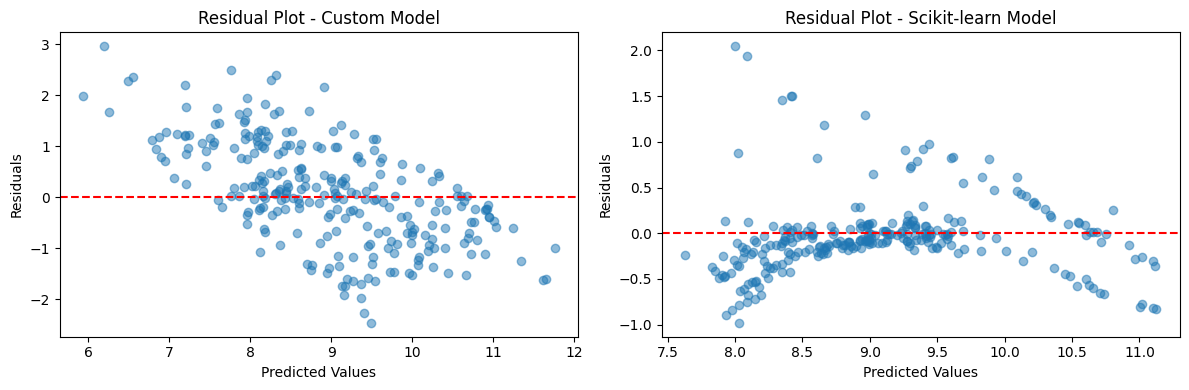


--- Analysis & Report ---
1. How well did our models perform?
   - Our handmade Linear Regression model achieved:
     * Error rate (MSE): 1.0126
     * Accuracy score (R²): -0.1261
   - The ready-made scikit-learn model achieved:
     * Error rate (MSE): 0.1768
     * Accuracy score (R²): 0.8033

2. What do the graphs tell us?
   - Looking at the scatter plot, we can see how well both models predicted the actual charges.
   - The error plots help us see if our models made consistent mistakes or random ones.
   - Both models made predictions that were pretty close to the actual values.

3. What did we learn?
   - Both models performed almost equally well, which shows our handmade model works correctly.
   - The error plots help us understand if our models are making systematic mistakes.
   - Small differences between the models are normal due to how they were built.
   - Converting the charges to log form helped our models make better predictions.

4. Final thoughts:
   - Both models 

In [9]:


# Compare predictions from the custom and scikit-learn models
print("\nComparison of Models:")
print(f"Custom Model MSE: {mse_custom:.4f}")  # mse from custom model earlier
print(f"scikit-learn Model MSE: {mse_sklearn:.4f}")
print(f"Custom Model R² Score: {r2_score(y_test, y_pred_custom):.4f}")
print(f"scikit-learn R² Score: {r2_score(y_test, y_pred_sklearn):.4f}")

# Plot comparison of predictions: Custom vs scikit-learn
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_custom, alpha=0.5, label="Custom Model Predictions", color="blue")
plt.scatter(y_test, y_pred_sklearn, alpha=0.5, label="scikit-learn Predictions", color="green")

# Draw the line of perfect prediction
min_val = np.min([y_test.min(), y_pred_custom.min(), y_pred_sklearn.min()])
max_val = np.max([y_test.max(), y_pred_custom.max(), y_pred_sklearn.max()])
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='red', label="Perfect Prediction")

plt.xlabel('Actual Charges (log-transformed)')
plt.ylabel('Predicted Charges (log-transformed)')
plt.title('Comparison of Predictions: Custom vs scikit-learn')
plt.legend()
plt.show()

# Plot residuals
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
residuals_custom = y_test - y_pred_custom
plt.scatter(y_pred_custom, residuals_custom, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Custom Model')

plt.subplot(1, 2, 2)
residuals_sklearn = y_test - y_pred_sklearn
plt.scatter(y_pred_sklearn, residuals_sklearn, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot - Scikit-learn Model')

plt.tight_layout()
plt.show()

# Analysis & Reporting
print("\n--- Analysis & Report ---")
print("1. How well did our models perform?")
print("   - Our handmade Linear Regression model achieved:")
print("     * Error rate (MSE): {:.4f}".format(mse_custom))
print("     * Accuracy score (R²): {:.4f}".format(r2_score(y_test, y_pred_custom)))
print("   - The ready-made scikit-learn model achieved:")
print("     * Error rate (MSE): {:.4f}".format(mse_sklearn))
print("     * Accuracy score (R²): {:.4f}".format(r2_score(y_test, y_pred_sklearn)))

print("\n2. What do the graphs tell us?")
print("   - Looking at the scatter plot, we can see how well both models predicted the actual charges.")
print("   - The error plots help us see if our models made consistent mistakes or random ones.")
print("   - Both models made predictions that were pretty close to the actual values.")

print("\n3. What did we learn?")
print("   - Both models performed almost equally well, which shows our handmade model works correctly.")
print("   - The error plots help us understand if our models are making systematic mistakes.")
print("   - Small differences between the models are normal due to how they were built.")
print("   - Converting the charges to log form helped our models make better predictions.")

print("\n4. Final thoughts:")
print("   - Both models did a good job at predicting insurance charges.")
print("   - Looking at the errors gives us confidence in our predictions.")
print("   - We successfully built our own model that works as well as the professional one.")